In [48]:
%matplotlib inline

In [49]:
import pandas as pd
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
import pnlclass

In [50]:
btcusdhist = pd.read_csv('historical/btcusdhist.csv')

btcusdhist['time']=btcusdhist['time'].apply(lambda x: x.split('.')[0])
btcusdhist['time']=pd.to_datetime(btcusdhist['time'],format='%Y-%m-%dD%H:%M:%S')

btcusdhist=btcusdhist[['time','low','high','open','close','vol']]
btcusdhist.set_index(btcusdhist.time,inplace=True)
btcusdhist=btcusdhist[['low','high','open','close','vol']]

In [51]:
training = btcusdhist[btcusdhist.index <= pd.to_datetime('2017-09-02 00:00:00')]
testing = btcusdhist[(pd.to_datetime('2017-09-04 09:00:00') >= btcusdhist.index)&(btcusdhist.index > pd.to_datetime('2017-09-04 00:00:00'))]

In [52]:
arr=training["close"].as_matrix()[::-1]
testarr = testing['close'].as_matrix()[::-1]

In [53]:
maxprice = arr.max()
minprice = arr.min()
priceDsize = int(round(maxprice - minprice))

m = 10
k = 5
posDsize = 2*m+1
actionDsize = 2*k+1

actions = list(range(-k,k+1))

def price2index(x):
    return (int(round((x-minprice)*100)))
def pos2index(x):
    return x+10

In [54]:
uniqueprices = np.unique(arr)
#for later checking for complete exploration of visisted price state space
p2i = lambda x:int(round((x-minprice)*100))
vp2i = np.vectorize(p2i)
upidx = vp2i(uniqueprices)

In [55]:
kappa=1e-4
gamma=0.999
alpha=0.001
epsilon=0.1 #run without initially, then with
converge=1e-6
delta = np.inf
firstprice=testarr[0]

In [56]:
q = np.load('q_greedy.npy')

In [26]:
# Passive Clustering

cumpos = 0
state = [price2index(firstprice),pos2index(cumpos)]
btc=PnL()
lop = [] #list of pnl's
los = [] # list of skips
for i in range(5000):
    state = [price2index(testarr[i]),cumpos]
    action = np.argmax(np.absolute(q[tuple(state)]))
    if q[tuple(state+[action])] == 0:
        action = 5
        los.append(0)
        state.append(action)
    else:
        los.append(1)
        state.append(action)
    chpos = actions[action]
    cumpos += chpos
    if cumpos > 10:
        chpos = 0
        cumpos = 10
    elif cumpos < -10:
        chpos = 0
        cumpos = -10
    btc.fill(chpos,testarr[i])
    pnl = btc.update(testarr[i])
    lop.append(pnl)

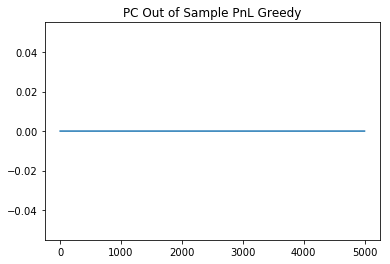

In [34]:
plt.plot(lop)
plt.title('PC Out of Sample PnL Greedy')

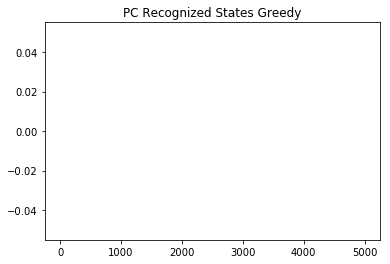

In [35]:
plt.bar(range(5000),los)
plt.title('PC Recognized States Greedy')

In [47]:
print('Were there any recognized states in PC Greedy Out of Sample?\n' + str(1 in los))

Were there any recognized states in PC Greedy Out of Sample?
False


In [60]:
# Price Snapping

cumpos = 0
btc=PnL()
lop = [] #list of pnl's
los = [] # list of skips
for i in range(5000):
    nearestidx = (np.abs(uniqueprices-testarr[i])).argmin()
    nearest = uniqueprices[nearestidx]
    state = [price2index(nearest),cumpos]
    action = np.argmax(np.absolute(q[tuple(state)]))
    if q[tuple(state+[action])] == 0:
        action = 5
        los.append(0)
        state.append(action)
    else:
        los.append(1)
        state.append(action)
    chpos = actions[action]
    cumpos += chpos
    if cumpos > 10:
        chpos = 0
        cumpos = 10
    elif cumpos < -10:
        chpos = 0
        cumpos = -10
    btc.fill(chpos,testarr[i])
    pnl = btc.update(testarr[i])
    lop.append(pnl)

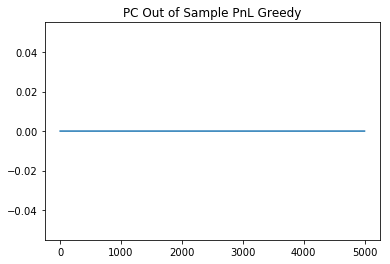

In [61]:
plt.plot(lop)
plt.title('PC Out of Sample PnL Greedy')

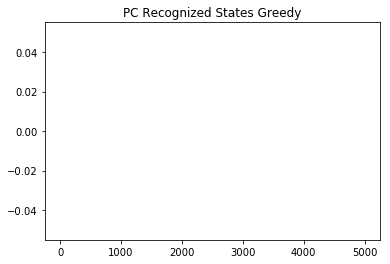

In [62]:
plt.bar(range(5000),los)
plt.title('PC Recognized States Greedy')

In [63]:
print('Were there any recognized states in PC Greedy Out of Sample?\n' + str(1 in los))

Were there any recognized states in PC Greedy Out of Sample?
False


#### Note:
It appears the greedy action makes it impossible for the cumulative position to be 0 by the start time of the testing set. Therefore, any state where `cumpos = 0` in the q matrix will not have been visited and will cause the agent to not take action.

-pm